In [1]:

from helper_code import *
import numpy as np, os, sys, joblib
import ecg_plot
import pandas as pd
from glob import glob
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tsai.all import *
import torch
from sklearn.metrics import classification_report
import transformation_funcs as tfs
import seaborn as sns
from torchsummary import summary
torch.cuda.set_device(2) 

In [2]:

# DATASET_NAME = "WFDB_CPSC2018_signitured"
DATASET_NAME = "WFDB_ChapmanShaoxing_signitured"
X = np.load('./data/big_numpy_datasets/%s.npy'%DATASET_NAME, mmap_mode='c')
label_df = pd.read_csv("data/%s.csv"%DATASET_NAME).drop(columns=["headers","leads"])
y = snomedConvert(label_df)
# get diseases that exist in more than 5 percent of the samples
y=y[y.columns[y.sum()>(0.05*y.shape[0])]]
y.reset_index(drop=True)
X.shape,y.shape

((10247, 12, 5000), (10247, 8))

In [70]:
# more than 1 label, 0 labels, total num labels, 
np.sum(y.sum(axis=1)>1),np.sum(y.sum(axis=1)==0),y.sum().sum()

(3334, 337, 13979)

In [72]:

DATASET_NAME = "WFDB_CPSC2018_signitured"
X = np.load('./data/big_numpy_datasets/%s.npy'%DATASET_NAME, mmap_mode='c')
label_df = pd.read_csv("data/%s.csv"%DATASET_NAME).drop(columns=["headers","leads"])
y = snomedConvert(label_df)
# get diseases that exist in more than 5 percent of the samples
y=y[y.columns[y.sum()>(0.05*y.shape[0])]]
y.reset_index(drop=True)
X.shape,y.shape

((6877, 12, 14000), (6877, 7))

In [73]:
# more than 1 label, 0 labels, total num labels, 
np.sum(y.sum(axis=1)>1),np.sum(y.sum(axis=1)==0),y.sum().sum()

(394, 368, 6903)

In [75]:
print(y.sum().to_latex())

\begin{tabular}{lr}
\toprule
{} &     0 \\
\midrule
right bundle branch block    &  1857 \\
ventricular ectopics         &   700 \\
atrial fibrillation          &  1221 \\
1st degree av block          &   722 \\
premature atrial contraction &   616 \\
sinus rhythm                 &   918 \\
st depression                &   869 \\
\bottomrule
\end{tabular}



In [101]:

DATASET_NAME = "WFDB_PTBXL_signitured"
X = np.load('./data/big_numpy_datasets/%s.npy'%DATASET_NAME, mmap_mode='c')
label_df = pd.read_csv("data/%s.csv"%DATASET_NAME).drop(columns=["headers","leads"])
y = snomedConvert(label_df)
# get diseases that exist in more than 5 percent of the samples
y=y[y.columns[y.sum()>(0.01*y.shape[0])]]
y.reset_index(drop=True)
X.shape,y.shape

((21837, 12, 5000), (21837, 30))

In [102]:
# more than 1 label, 0 labels, total num labels, 
np.sum(y.sum(axis=1)>1),np.sum(y.sum(axis=1)==0),y.sum().sum()

(14605, 26, 54457)

In [103]:
print(y.sum().to_latex())

\begin{tabular}{lr}
\toprule
{} &      0 \\
\midrule
pacing rhythm                                    &    296 \\
left axis deviation                              &   5146 \\
right axis deviation                             &    343 \\
anterior myocardial infarction                   &    354 \\
s t changes                                      &    770 \\
t wave inversion                                 &    294 \\
myocardial ischemia                              &   2175 \\
myocardial infarction                            &   5261 \\
left ventricular hypertrophy                     &   2359 \\
ventricular ectopics                             &   1154 \\
atrial fibrillation                              &   1514 \\
left bundle branch block                         &    536 \\
qwave abnormal                                   &    548 \\
t wave abnormal                                  &   2345 \\
prolonged pr interval                            &    340 \\
abnormal QRS                    

Table of past-work (Hong et al.)

In [91]:
df = pd.read_csv("csvs/physionet-2020-survey Hongetal.csv")[0:5]
top_df = df[["Rank","Data preprocessing","Data augmentation"]]
print(top_df.set_index("Rank").to_latex())

\begin{tabular}{lll}
\toprule
{} &                                                                 Data preprocessing &                                                                          Data augmentation \\
Rank &                                                                                    &                                                                                            \\
\midrule
1    &  Sampling rate 500Hz; Bandwidth 3 - 45 Hz; Value -1 - 1; Window size 15s 0-padding &                                                                                         No \\
2    &                Sampling rate 257 Hz; Value -1 - 1; Window size 4096(16s) 0-padding &                                                                                         No \\
3    &   Sampling rate 500Hz; Window size 30s 0-padding; Exclude 4 leads; Wavelet denoise &                                                                  With external data: Hefei \\
4    &                     Sampli

,Data preprocessing,Data augmentation
Rank,,
1,Sampling rate 500Hz; Bandwidth 3 - 45 Hz; Value -1 - 1; Window size 15s 0-padding,No
2,Sampling rate 257 Hz; Value -1 - 1; Window size 4096(16s) 0-padding,No
3,Sampling rate 500Hz; Window size 30s 0-padding; Exclude 4 leads; Wavelet denoise,With external data: Hefei
4,Sampling rate 500Hz; Value -1 - 1; Window size 10240(20.48 s),Add noise and drift
5,Sampling rate 250Hz; Value normalized,"Add or filter frequency components; Substitute, shuffle, invert, filt and scale lead data"


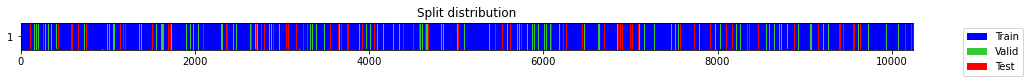

Counts by label: {'right bundle branch block': 454, 'atrial fibrillation': 1780, 't wave abnormal': 1876, 'sinus bradycardia': 3889, 'atrial flutter': 445, 'nonspecific st t abnormality': 1158, 'st depression': 402, 'sinus rhythm': 1826, 'left ventricular high voltage': 1295, 'sinus tachycardia': 1568, '1st degree av block': 247, 't wave inversion': 157, 'left bundle branch block': 205, 'qwave abnormal': 235, 'premature atrial contraction': 258, 'av block': 166, 'ventricular premature beats': 294, 'nonspecific intraventricular conduction disorder': 235, 'low qrs voltages': 249, 'left axis deviation': 382, 'right axis deviation': 215, 'countercolockwise rotation': 162, 'st elevation': 176, 'supraventricular tachycardia': 587, 'atrial tachycardia': 121}


In [103]:

cv_splits = get_splits(y.to_numpy(), valid_size=.1,test_size=0.1, stratify=False, random_state=23, shuffle=True)
y_multi = []
for i,row in y.iterrows():
    sample_labels = []
    for i,r in enumerate(row):
        if r == True:
            sample_labels.append(y.columns[i])
        
    y_multi.append(list(tuple(sample_labels)))
label_counts = collections.Counter([a for r in y_multi for a in r])
print('Counts by label:', dict(label_counts))

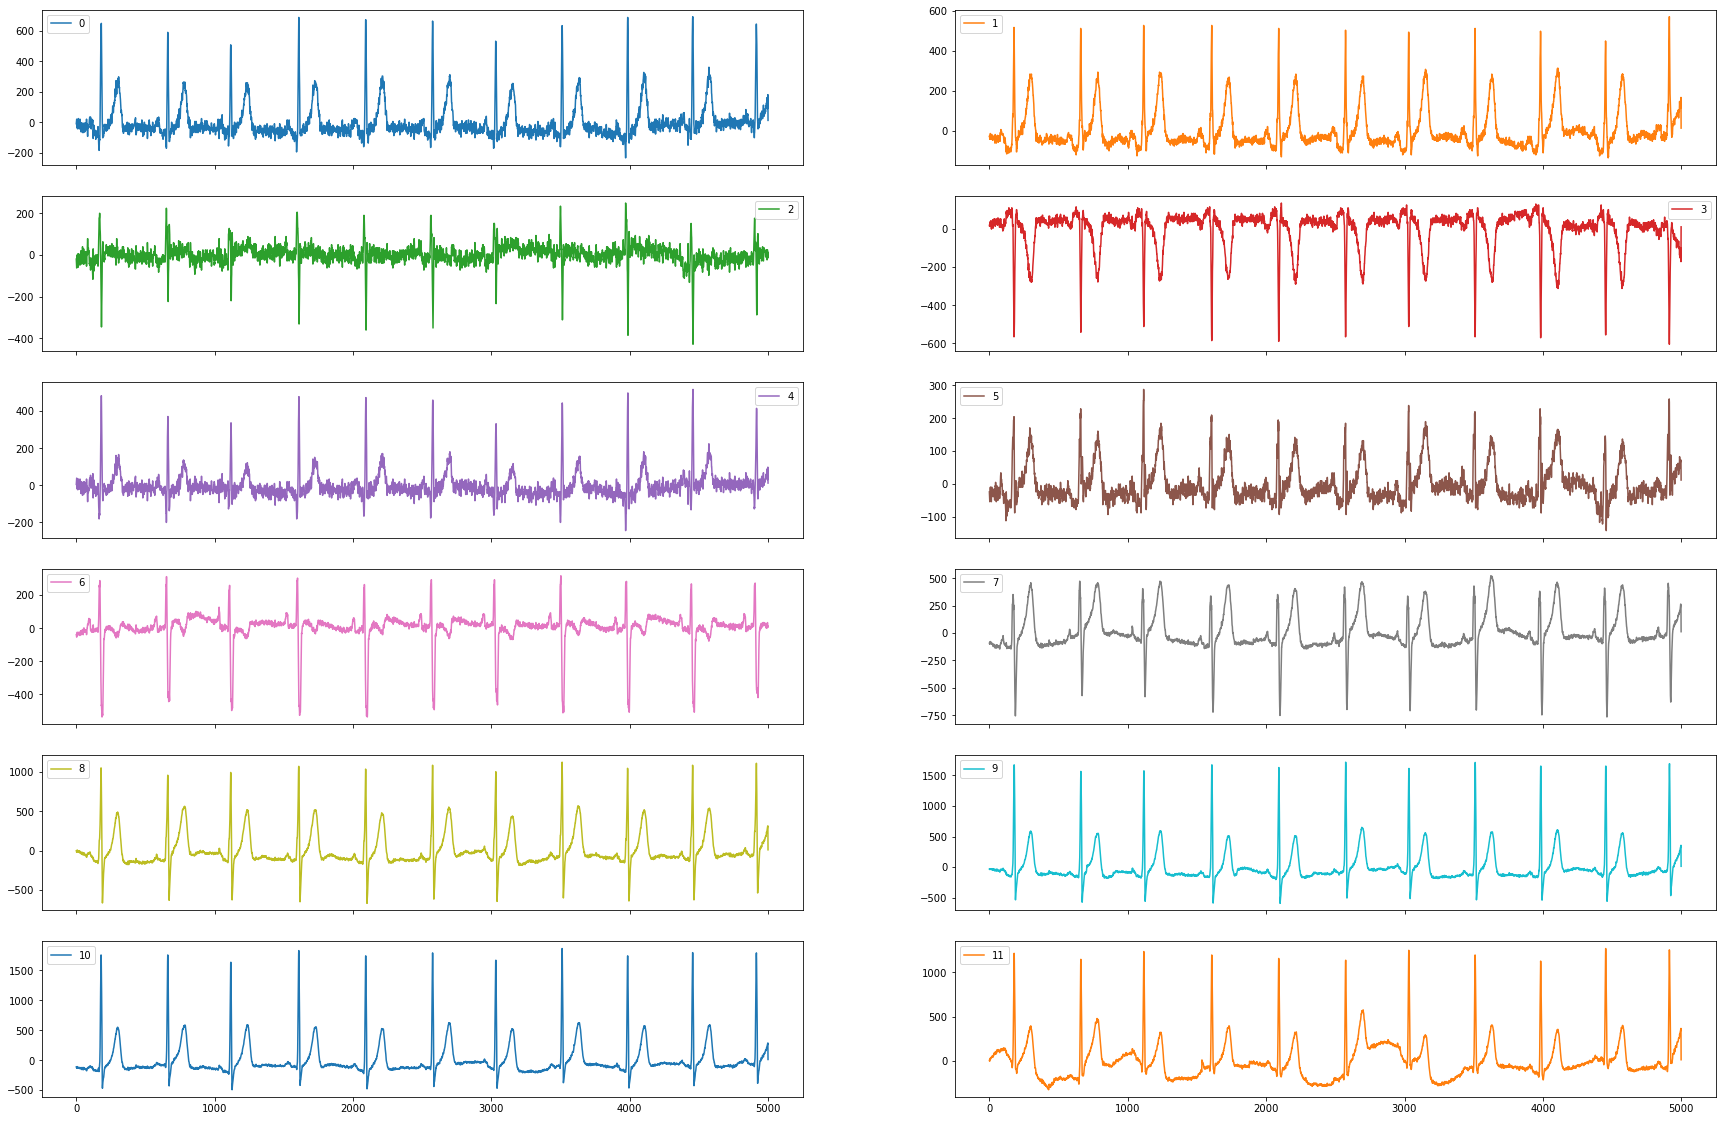

In [105]:
fig = pd.DataFrame(X[6]).T.plot.line(subplots = True,layout=(6,2), figsize=(30,20))

epoch,train_loss,valid_loss,accuracy_multi,balanced_accuracy_multi,precision_multi,recall_multi,specificity_multi,F1_multi,time
0,0.264609,0.214225,0.923823,0.713219,0.864057,0.435994,0.990445,0.578273,00:13
1,0.214371,0.208563,0.923338,0.760465,0.745751,0.546113,0.974816,0.629984,00:13
2,0.186455,0.173778,0.935630,0.791200,0.812354,0.601143,0.981257,0.690571,00:13
3,0.165207,0.157914,0.941938,0.812662,0.834017,0.642599,0.982726,0.725468,00:14
4,0.152514,0.144264,0.949054,0.836882,0.859050,0.689206,0.984557,0.764472,00:14
5,0.149052,0.143021,0.947275,0.834934,0.843622,0.687139,0.982728,0.757029,00:14
6,0.139106,0.135211,0.952774,0.848663,0.870890,0.711655,0.985671,0.782956,00:14
7,0.134228,0.139678,0.951642,0.844315,0.867352,0.703144,0.985485,0.776434,00:14
8,0.129858,0.126882,0.956008,0.855102,0.888621,0.722330,0.987874,0.796455,00:14
9,0.130383,0.146051,0.948569,0.833001,0.861424,0.680889,0.985114,0.760549,00:14


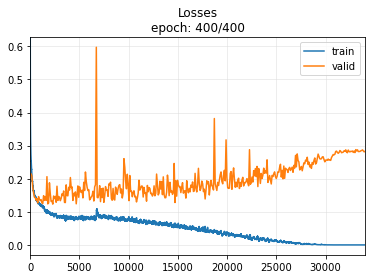

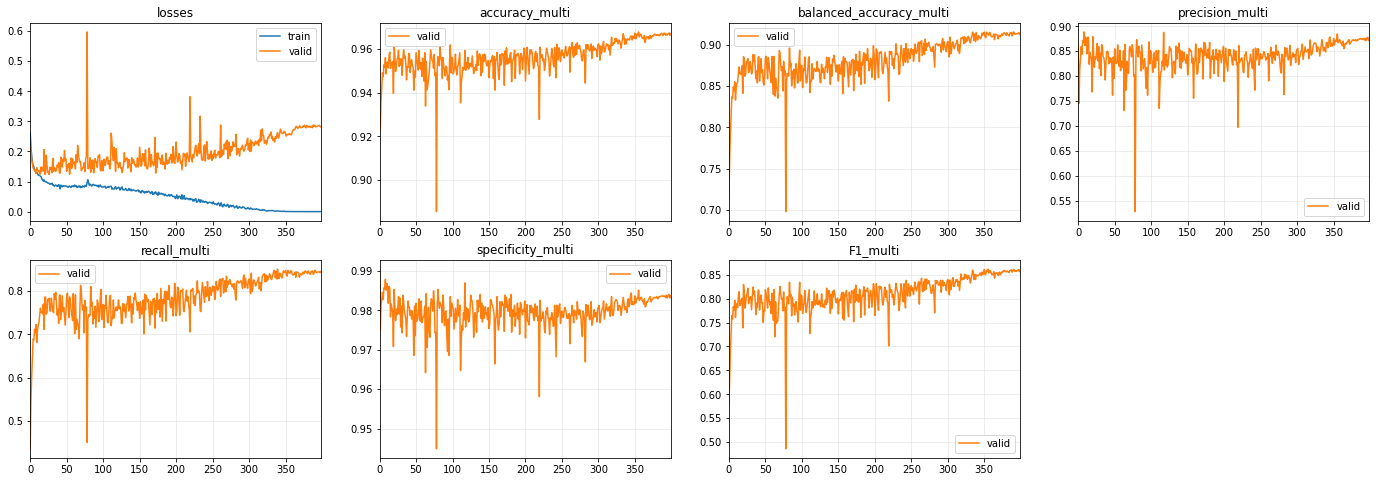

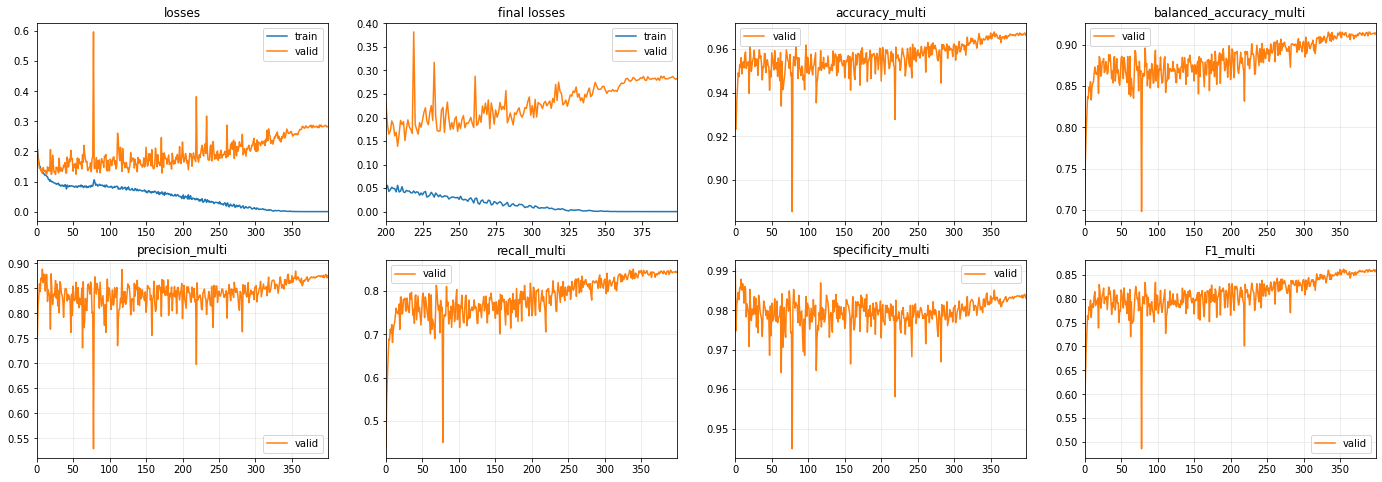

In [61]:
max_len = 5000
sf = 0.3
tfms  = [None, TSMultiLabelClassification()]
batch_tfms = [
#              TSStandardize(by_sample=True),
                tfs.Normalize(),
                tfs.Scale(scale_factor=sf,),
                tfs.BandPass(int(sf*500),low_cut=60, high_cut=1,leads=12,),
#               tfs.RandomShift(0.1),
#               tfs.MulNoise(6),
#               tfs.CutOutWhenTraining(),
             ]

dsets = TSDatasets(X.astype(float)[:,:,0:max_len], y_multi, tfms=tfms, splits=cv_splits) # inplace=True by default
dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[64, 128], batch_tfms=batch_tfms, num_workers=0)
metrics =[accuracy_multi, balanced_accuracy_multi, precision_multi, recall_multi, specificity_multi, F1_multi] 
#     model = MiniRocketPlus(dls.vars, dls.c,dls.len)
model = InceptionTimePlus(dls.vars, dls.c, dls.len, depth=10,ks = 100 )
#     model = XceptionTimePlus(dls.vars, dls.c)
#     model = MultiTSTPlus(dls.vars, dls.c,int(sf*2500),max_seq_len=200,attn_dropout=0.5,dropout=0.3)

#     learn = Learner(dls, model, metrics=metrics,loss_func = BCEWithLogitsLossFlat(pos_weight=dls.train.cws.sqrt()),cbs=[ShowGraph()],)
learn = Learner(dls,model, metrics=metrics,cbs=[ShowGraph()])
learn.fit_one_cycle(400, lr_max=1e-1)
learn.recorder.plot_metrics()

In [ ]:
import torchaudio
torchaudio.__version__,torch.__version__,tsai.__version__


In [ ]:
#     model = MiniRocketPlus(dls.vars, dls.c,dls.len)
model = InceptionTimePlus(dls.vars, dls.c, dls.len, depth=8,)
#     model = XceptionTimePlus(dls.vars, dls.c)
#     model = MultiTSTPlus(dls.vars, dls.c,500,)

learn = Learner(dls, model, metrics=metrics,loss_func = BCEWithLogitsLossFlat(pos_weight=dls.train.cws.sqrt()),cbs=[ShowGraph()],)
#     learn = Learner(dls,model, metrics=metrics,cbs=[ShowGraph()],)

In [62]:
tfms  = [None, TSMultiLabelClassification()]
batch_tfms = [
#              TSStandardize(by_sample=True),
                tfs.Normalize(),
                tfs.Scale(scale_factor=sf,),
                tfs.BandPass(int(sf*500),low_cut=60, high_cut=1,leads=12,),
#               tfs.RandomShift(0.1),
#               tfs.MulNoise(6),
#               tfs.CutOutWhenTraining(),
             ]
reports = []
# for cv_num in range(1):
fold_splits = cv_splits
dsets = TSDatasets(X.astype(float), y_multi, tfms=tfms, splits=(fold_splits[0],fold_splits[2])) # inplace=True by default
dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[128, 128], batch_tfms=batch_tfms, num_workers=0)
# model = InceptionTimePlus(dls.vars, dls.c, dls.len, depth=8,)
#     learn = Learner(dls, model, metrics=metrics, 
#                     cbs=[ShowGraph()],)
#     learn.load("inception_augmented_%s"%cv_num)
valid_probas, valid_targets, valid_preds = learn.get_preds(dl=dls.valid, with_decoded=True)

y_pred = (valid_preds>0)
y_test = valid_targets

report = classification_report(y_test, y_pred,target_names = dls.vocab.o2i.keys(),digits=3,output_dict=True)
reports.append(report)
for report in reports:
    for k,v in report.items():
        report[k] = report[k]["f1-score"]
df = pd.DataFrame(reports).median()
df

1st degree av block             0.845528
atrial fibrillation             0.917355
left bundle branch block        0.923077
premature atrial contraction    0.636364
right bundle branch block       0.938776
sinus rhythm                    0.644737
st depression                   0.787879
st elevation                    0.432432
ventricular ectopics            0.792208
micro avg                       0.824611
macro avg                       0.768706
weighted avg                    0.816673
samples avg                     0.765163
dtype: float64